# Embedding Generation via Backbone Registry (TerraMind)

This example shows how to extract a TerraMind embedding for a single Sentinel-2 RGB input image. Within TerraTorch, the `EmbeddingGenerationTask` enables automatic no-code / low-code embedding extraction for any supported backbone, and we recommend checking out the  `embedding_generation_burnscars.ipynb` tutorial if you want to generate embeddings for an entire dataset.

This example, instead, focuses on a more flexible setup: It demonstrates how to use the TerraTorch Backbone Registry directly to build your own pipeline and extract embeddings manually.

In [ ]:
from pathlib import Path

import torch
import rioxarray as rxr
from huggingface_hub import hf_hub_download

import numpy as np

# Select device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

In [2]:
from terratorch.registry import BACKBONE_REGISTRY

# Build model using TerraTorch Backbone Registry
model = BACKBONE_REGISTRY.build(
    "terramind_v1_base",
    # modalities=["S2L2A"], # all S2 bands
    modalities=["S2RGB"], # S2 RGB bands
    pretrained=True,
)

model = model.to(device)
model.eval()

TerraMindViT(
  (encoder_embeddings): ModuleDict(
    (untok_sen2rgb@224): ImageEncoderEmbedding(
      (proj): Linear(in_features=768, out_features=768, bias=False)
    )
  )
  (encoder): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm()
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=False)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm()
      (mlp): GatedMlp(
        (fc1): Linear(in_features=768, out_features=2048, bias=False)
        (act): SiLU()
        (fc2): Linear(in_features=2048, out_features=768, bias=False)
        (fc3): Linear(in_features=768, out_features=2048, bias=False)
      )
    )
  )
  (encoder_norm): LayerNorm()
  (tokenizer): ModuleDict()
)

In [ ]:
# Download example input image
image_path = Path('examples/S2L2A/Santiago.tif')

if not image_path.exists():
    hf_hub_download(repo_id='ibm-esa-geospatial/Examples', filename='S2L2A/Santiago.tif', repo_type='dataset', local_dir='examples/')

In [8]:
# TerraMind pretraining values
means={
  "S2L2A": [1390.458, 1503.317, 1718.197, 1853.910, 2199.100, 2779.975, 2987.011, 3083.234, 3132.220, 3162.988, 2424.884, 1857.648],
  "RGB": [87.271, 80.931, 66.667]
}
stds={
  "S2L2A": [2106.761, 2141.107, 2038.973, 2134.138, 2085.321, 1889.926, 1820.257, 1871.918, 1753.829, 1797.379, 1434.261, 1334.311],
  "RGB": [58.767, 47.663, 42.631],
}

In [9]:
# Helpers to build RGB image out of S2 inputs
def rgb_smooth_quantiles(array, tolerance=0.02, scaling=0.5, default=2000):
    """
    array: numpy array with dimensions [C, H, W]
    returns 0-1 scaled array
    """

    # Get scaling thresholds for smoothing the brightness
    limit_low, median, limit_high = np.quantile(array, q=[tolerance, 0.5, 1. - tolerance])
    limit_high = limit_high.clip(default)  # Scale only pixels above default value
    limit_low = limit_low.clip(0, 1000)  # Scale only pixels below 1000
    limit_low = np.where(median > default / 2, limit_low, 0)  # Make image only darker if it is not dark already

    # Smooth very dark and bright values using linear scaling
    array = np.where(array >= limit_low, array, limit_low + (array - limit_low) * scaling)
    array = np.where(array <= limit_high, array, limit_high + (array - limit_high) * scaling)

    # Update scaling params using a 10th of the tolerance for max value
    limit_low, limit_high = np.quantile(array, q=[tolerance/10, 1. - tolerance/10])
    limit_high = limit_high.clip(default, 20000)  # Scale only pixels above default value
    limit_low = limit_low.clip(0, 500)  # Scale only pixels below 500
    limit_low = np.where(median > default / 2, limit_low, 0)  # Make image only darker if it is not dark already

    # Scale data to 0-1
    array = (array - limit_low) / (limit_high - limit_low)

    return array


def s2_to_rgb(rgb):
    rgb = rgb_smooth_quantiles(rgb)
    rgb = (rgb * 255).round().clip(0, 255).astype(np.uint8)

    return rgb

In [10]:
# Read in input image
data = rxr.open_rasterio(image_path).values

# Select RGB image of dimension 224x224
data = data[[3,2,1], 0:224, 0:224]
data = s2_to_rgb(data)

# Normalise with pretraining normalization values
data = ((data
        - np.array(means['RGB'])[:, None, None])/
          np.array(stds['RGB'])[:, None, None])

data.shape

(3, 224, 224)

In [11]:
# Create torch input of batch size 1
input = torch.tensor(data, dtype=torch.float, device=device).unsqueeze(0)
input.shape

torch.Size([1, 3, 224, 224])

## Retrieve Embedding

In [12]:
# We perform inference with the pretrained backbone and retrieve the last layer embedding
with torch.no_grad():
    embedding = model(input)[-1]
embedding = embedding.cpu().squeeze().numpy()

In [13]:
# Print output embedding
embedding.shape

(196, 768)

In [14]:
embedding

array([[-0.7788687 , -0.142709  ,  0.06924313, ...,  0.11080249,
         0.3922615 ,  0.12570836],
       [ 0.39078084, -0.5159049 ,  0.5379166 , ...,  0.33170065,
        -0.48347357, -0.07523818],
       [-1.0053269 ,  0.06282715, -0.3261542 , ...,  0.44651484,
        -0.32841712,  0.418891  ],
       ...,
       [-0.11946666,  0.41054553,  1.055068  , ...,  0.06063806,
         0.1364716 ,  0.5285593 ],
       [-1.1815182 , -0.02437578,  0.3072156 , ..., -0.02236425,
        -0.09850466,  0.85245246],
       [-0.6988548 , -0.05699293,  0.8739514 , ...,  0.23223276,
         0.42697096,  0.57979393]], shape=(196, 768), dtype=float32)

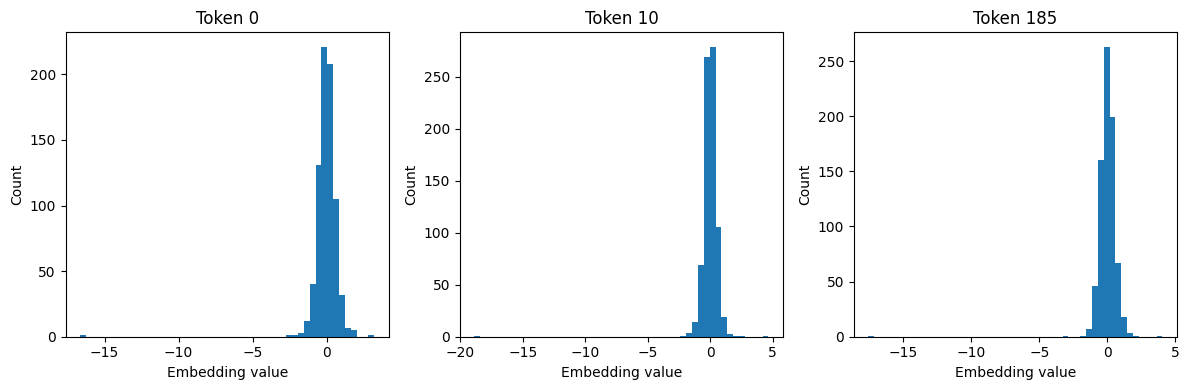

In [17]:
import matplotlib.pyplot as plt
import numpy as np

if hasattr(embedding, "detach"):
    embedding = embedding.detach().cpu().numpy()

# Pick 3 token indices
token_indices = [0, 10, 185]

plt.figure(figsize=(12, 4))

for i, t in enumerate(token_indices, 1):
    plt.subplot(1, 3, i)
    plt.hist(embedding[t], bins=50)
    plt.title(f"Token {t}")
    plt.xlabel("Embedding value")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()